In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from src.utils.common.setup import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
fn_random_start = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)
data_rnd = pd.read_csv(fn_random_start)

In [ ]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
data_rnd, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data_rnd)


In [ ]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
# interaction = 'energies'
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)
dfm_rnd = melt(data_rnd[data_rnd['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

# dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
#     data, interaction), var_name='idx', value_name=interaction)

### The problem

<AxesSubplot: xlabel='sensitivity_wrt_species-6', ylabel='Count'>

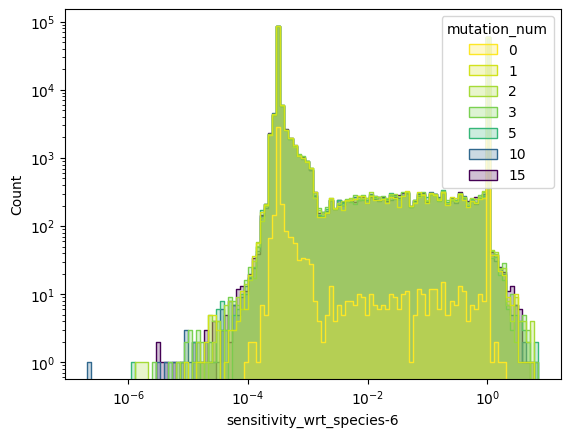

In [15]:
sns.histplot(data_rnd, x='sensitivity_wrt_species-6', hue='mutation_num', element='step', log_scale=[True, True], palette='viridis_r')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='sensitivity_wrt_species-6_diff_to_base_circuit', ylabel='Proportion'>

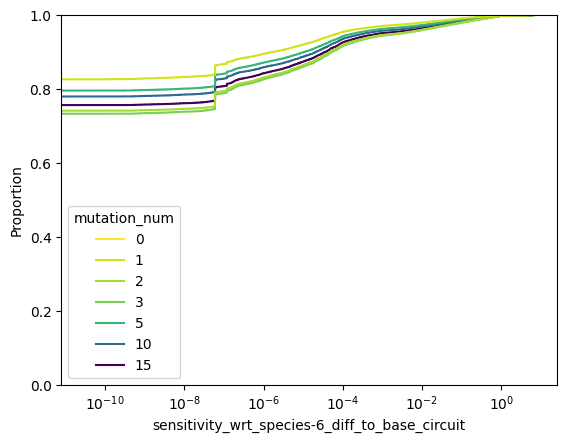

In [21]:
sns.ecdfplot(data_rnd, x='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num', log_scale=[True, False], palette='viridis_r')

<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

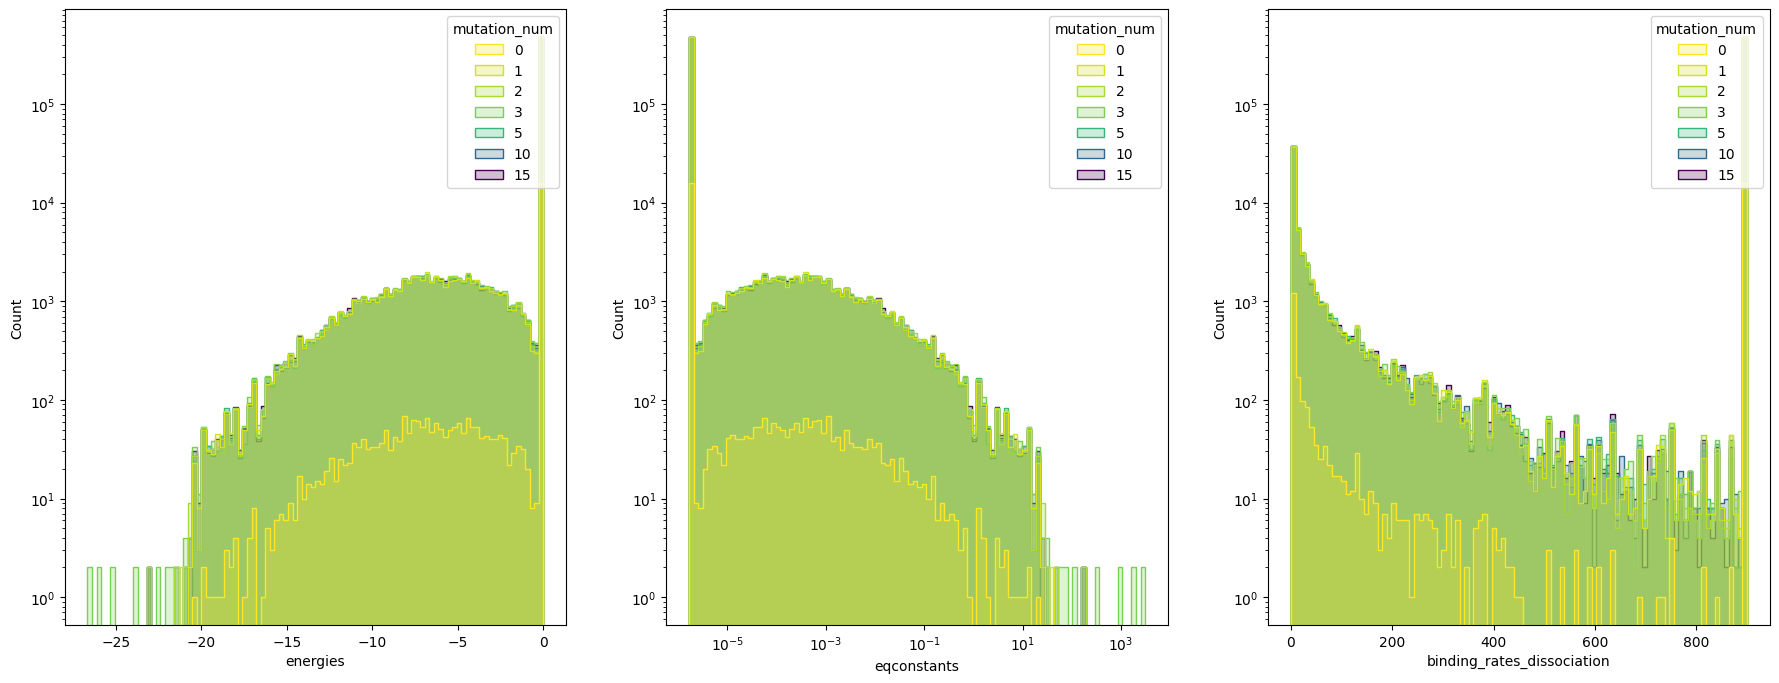

In [24]:

plt.figure(figsize=(22, 8))
ax = plt.subplot(1,3,1)
sns.histplot(dfm_rnd, x='energies', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.histplot(dfm_rnd, x='eqconstants', hue='mutation_num', log_scale=[True, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.histplot(dfm_rnd, x='binding_rates_dissociation', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')


### Investigate gain of interaction mutations

For some reason there's a weird ranking in the mutation numbers

In [6]:
low_circs = dfm[(dfm['num_interacting'] == 2) & (dfm['num_self_interacting'] == 1) & (dfm['mutation_num'] == 0)]['circuit_name'].unique()

gain_dfm = dfm[dfm['circuit_name'].isin(low_circs) & (dfm['mutation_num'] > 0) & (dfm['num_interacting'] >= 2) & (dfm['num_self_interacting'] >= 1)]

Text(0.5, 1.0, 'Unbiased reference circuits')

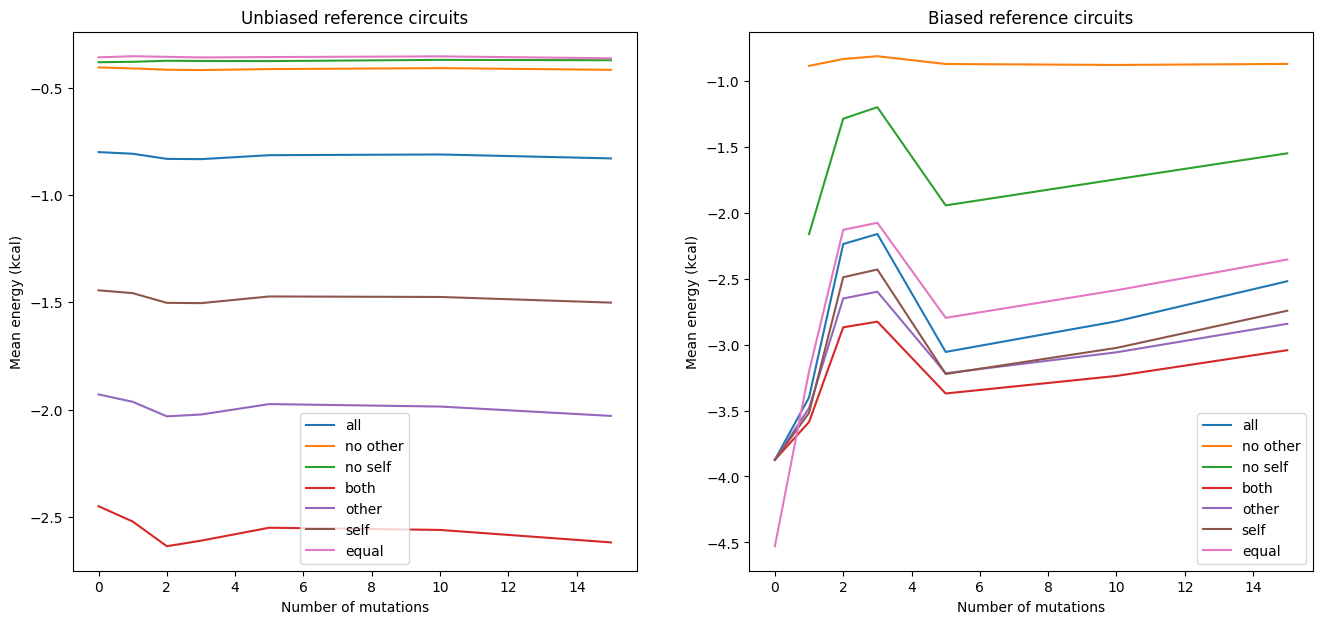

In [25]:
m = dfm.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm[dfm['num_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm[dfm['num_self_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm[dfm['num_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm[dfm['num_self_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm[dfm['num_self_interacting'] == dfm['num_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,2)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Biased reference circuits')


m = dfm_rnd.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm_rnd[dfm_rnd['num_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm_rnd[dfm_rnd['num_self_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm_rnd[dfm_rnd['num_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm_rnd[dfm_rnd['num_self_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Unbiased reference circuits')

Text(0.5, 0.98, 'Gain of interactions upon mutation')

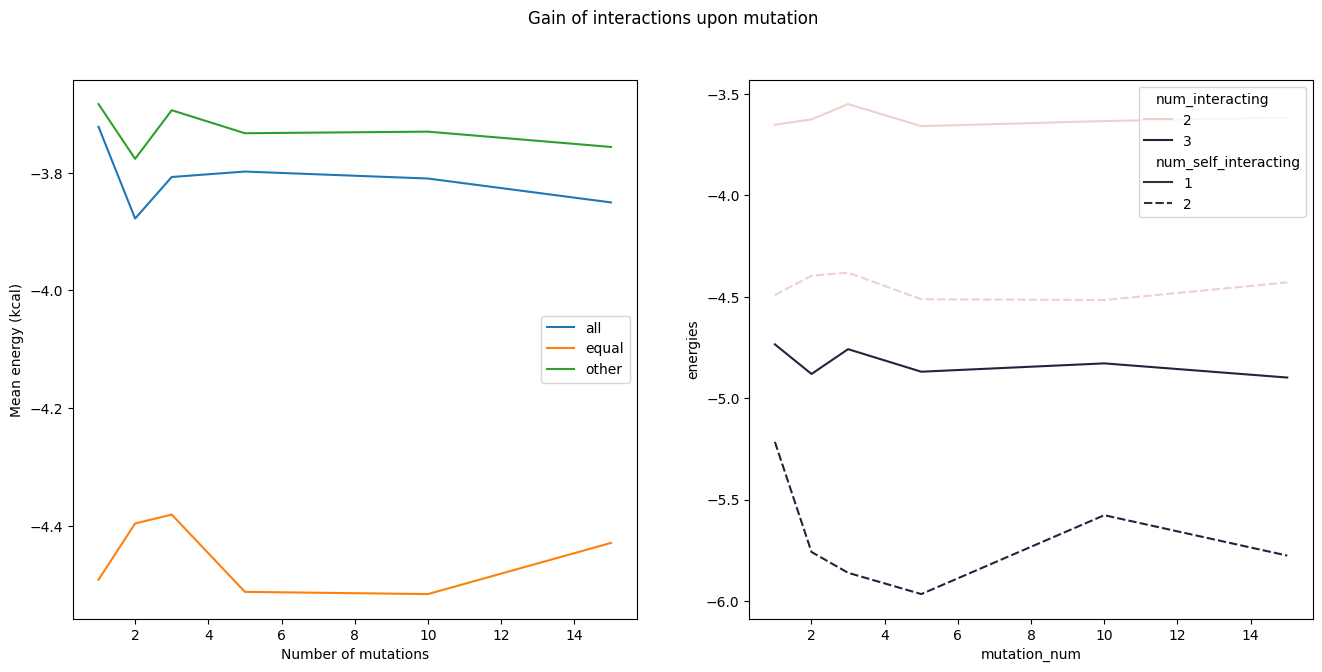

In [8]:
m = gain_dfm.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = gain_dfm[gain_dfm['num_interacting'] == gain_dfm['num_self_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = gain_dfm[gain_dfm['num_interacting'] > gain_dfm['num_self_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = gain_dfm[gain_dfm['num_self_interacting'] > gain_dfm['num_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


plt.figure(figsize=(16,7))
ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')

ax = plt.subplot(1,2,2)
m = gain_dfm.groupby(['mutation_num', 'num_interacting', 'num_self_interacting'], as_index=False).agg({'energies': 'mean'})
sns.lineplot(m, x='mutation_num', y='energies', hue='num_interacting', style='num_self_interacting')

plt.suptitle('Gain of interactions upon mutation')


In [9]:
dfm['bs_group_index'] = dfm['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs = dfm.explode(column=['num_bs', 'bs_group_index'])

Text(0.5, 0, 'Number of binding site groups')

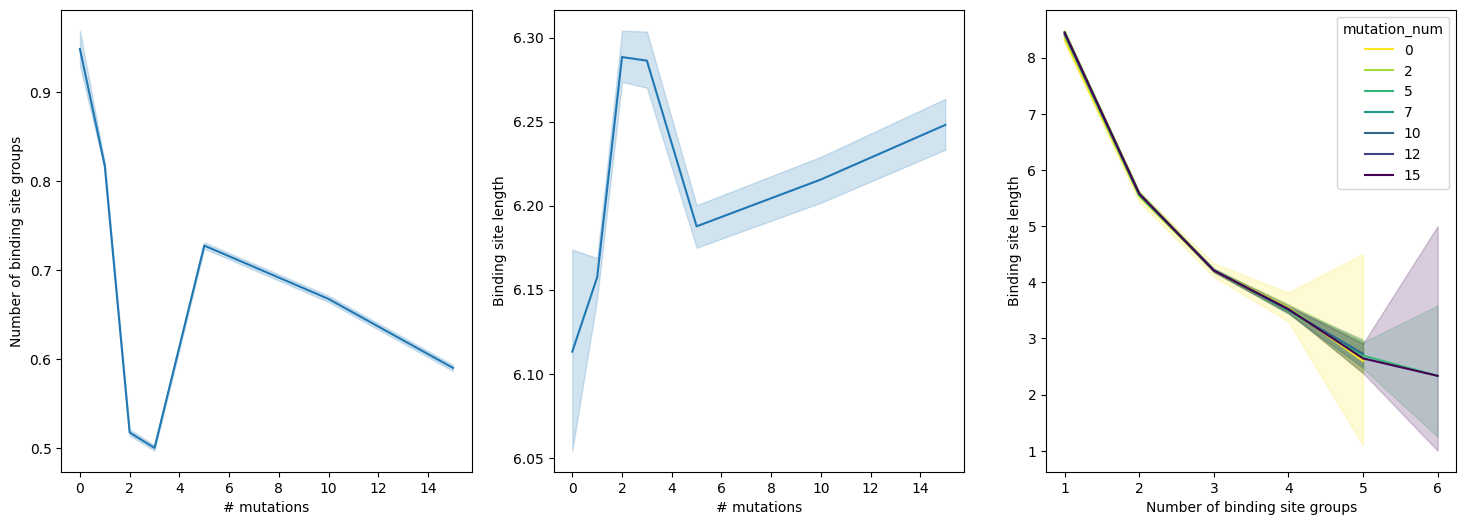

In [10]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')



In [26]:
dfm_rnd['bs_group_index'] = dfm_rnd['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs_rnd = dfm_rnd.explode(column=['num_bs', 'bs_group_index'])

Text(0.5, 0.98, 'Unbiased starting circuits')

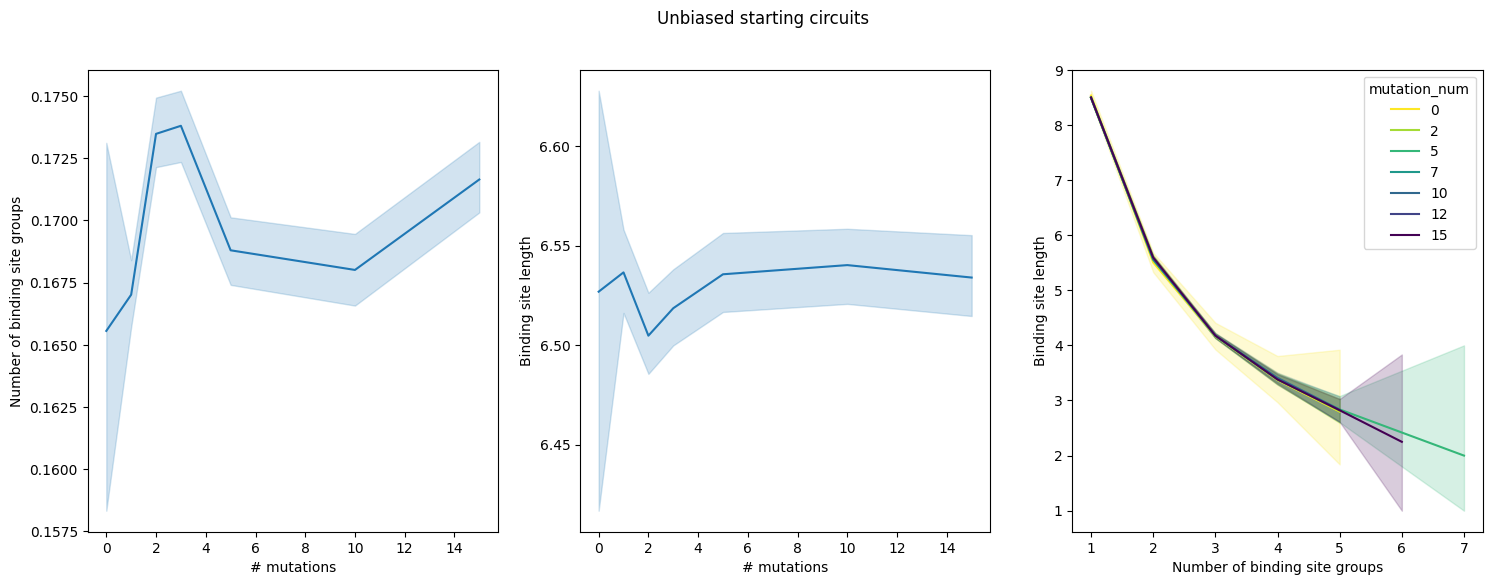

In [28]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm_rnd, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')

plt.suptitle('Unbiased starting circuits')


Text(0.5, 0, 'Binding site length')

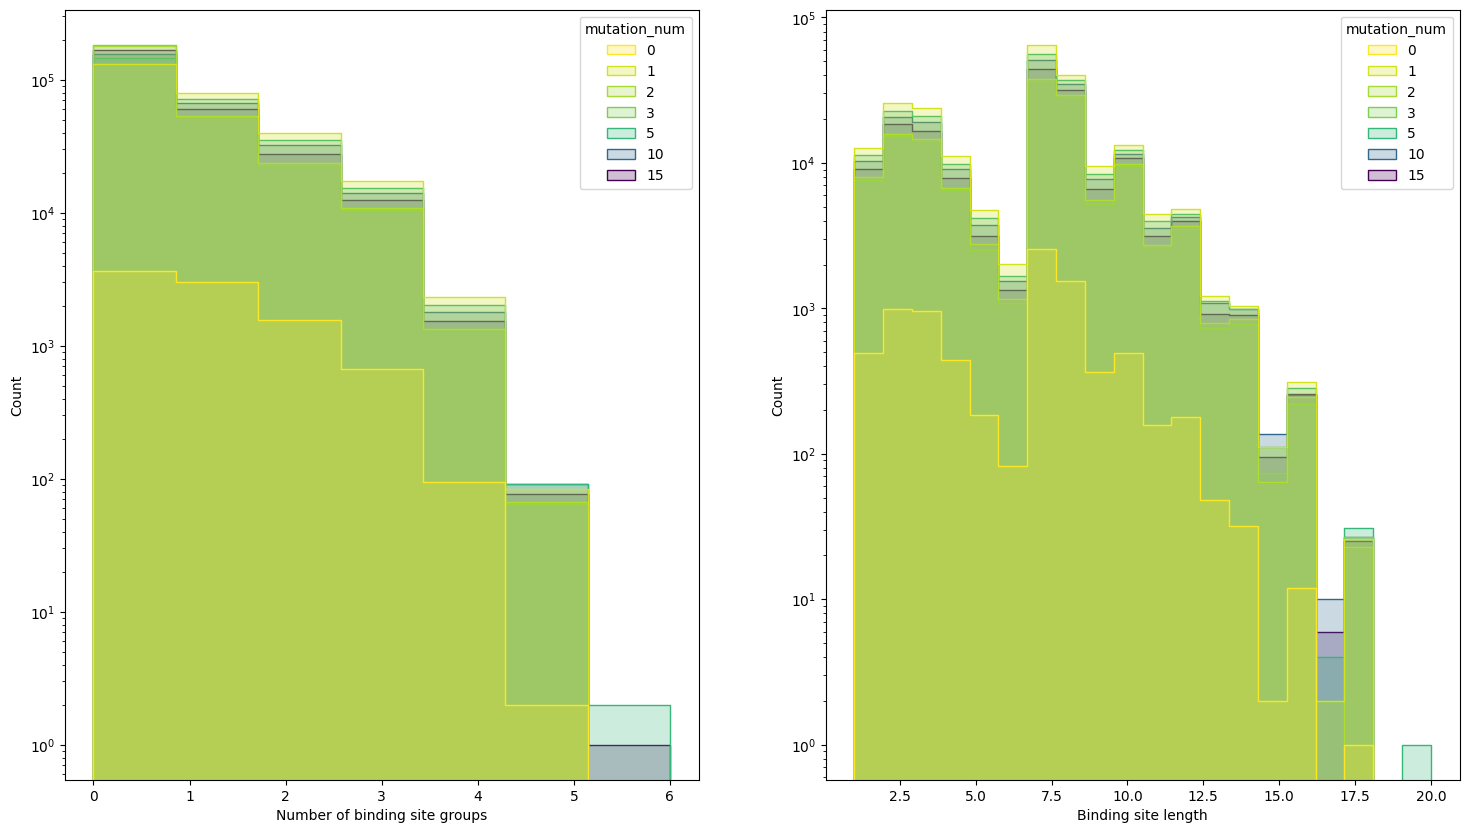

In [11]:
plt.figure(figsize=(18,10))
ax = plt.subplot(1,2,1)
sns.histplot(dfm, hue='mutation_num', x='num_groups', element='step', palette='viridis_r', bins = 7, log_scale=[False, True])
plt.xlabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.histplot(dfm_e_bs.reset_index(), hue='mutation_num', x='num_bs', palette='viridis_r', element='step', bins=20, log_scale=[False, True])
plt.xlabel('Binding site length')

Text(0, 0.5, 'Energies (kcal)')

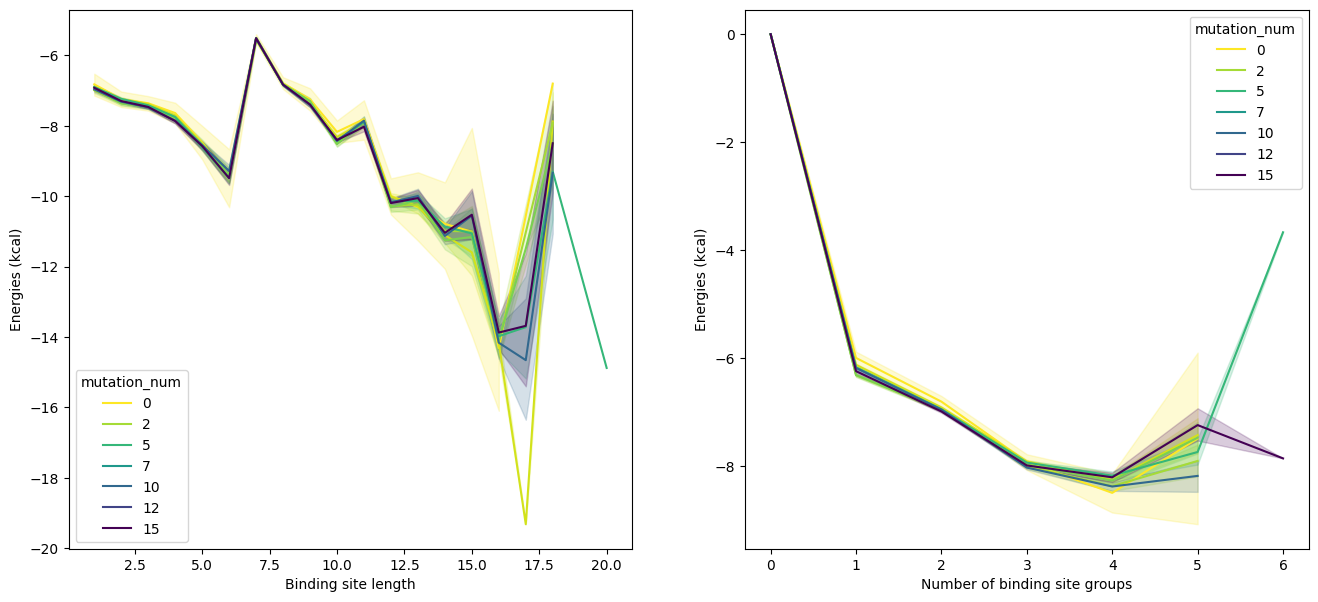

In [12]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_e_bs.reset_index(), x='num_bs', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Binding site length')
plt.ylabel('Energies (kcal)')
ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Number of binding site groups')
plt.ylabel('Energies (kcal)')